## impact function 

<AxesSubplot:title={'center':'DR 1: Drought on crop damage'}, xlabel='Intensity (WRSI value)', ylabel='Impact (%)'>

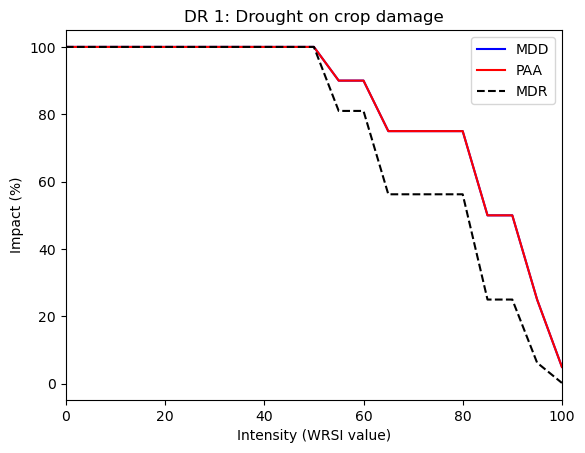

In [1]:
from climada.entity import ImpactFuncSet
from climada.util import ENT_TEMPLATE_XLS
import matplotlib.pyplot as plt

# provide absolute path of the input excel file
#file_name = ENT_TEMPLATE_XLS
file_name=f'/srv/repo/IBF_workshop_data/wrsi_data/ibf_drought_impact_ea_v0.xlsx'

imp_set_xlsx = ImpactFuncSet.from_excel(file_name)

imp_set_xlsx.plot()

## exposure 

In [2]:
from climada.entity import Exposures

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

from more_itertools import sliced
import geopandas as gp
CHUNK_SIZE = 500000

ex_db=pd.read_csv('/srv/repo/IBF_workshop_data/wrsi_data/ea_agr_spam.csv')

index_slices = sliced(range(len(ex_db)), CHUNK_SIZE)

ea_boundary=gp.read_file('/srv/repo/IBF_workshop_data/gis_files/ea_ghcf_icpac.shp')

edf_cont=[]
for index_slice in index_slices:
    chunk = ex_db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)


edf1=pd.concat(edf_cont)
edf2=edf1[['latitude','longitude','value']]
edf2

#file_path='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_climada/KEN_2021.csv'
#new_exp = Exposures(pd.read_csv(file_path))
#new_exp.check()


/tmp/ipykernel_46/3102281991.py:31: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  edf=gp.sjoin(ea_boundary,gdb)


,latitude,longitude,value
0,-2.625000,29.125000,3468556.4
0,-2.541667,29.958333,4510016.5
0,-2.541667,30.041667,5263846.5
0,-2.458333,30.041667,5953701.2
0,-2.458333,30.125000,3215008.4
...,...,...,...
10,-1.208333,30.208333,3617725.1
10,-1.208333,30.125000,4613908.3
10,-1.125000,30.291667,16556339.4
10,-1.125000,30.125000,3051267.8


In [ ]:
ex_db

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


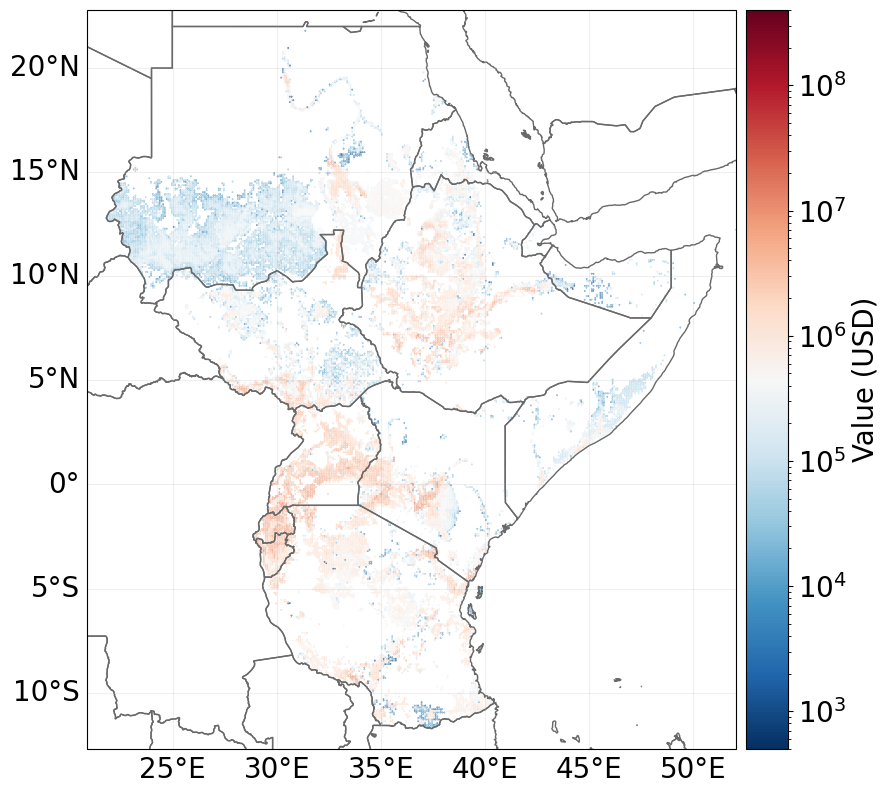

In [3]:
new_exp = Exposures(edf2)
new_exp.check()

norm = colors.LogNorm(vmin=500, vmax=4.0e8)

ax=new_exp.plot_hexbin(norm=norm, pop_name=False, cmap='RdBu_r', buffer=1)

#fname='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_ibf_data_resources/exposure-data/gis/ea_global_background.shp'

#ax.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None')

plt.savefig('/srv/repo/IBF_workshop_data/wrsi_data/ea_agr_spam_v1.png', bbox_inches='tight')


In [ ]:
from climada.entity import Exposures

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

file_path='/srv/repo/IBF_workshop_data/wrsi_data/ea_agr_spam.csv'


#file_path='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_climada/KEN_2021.csv'
new_exp = Exposures(pd.read_csv(file_path))
new_exp.check()

## hazard 

In [ ]:
import xarray as xr
import rioxarray 
import pandas as pd

wrsi_mean_path=f'/srv/repo/IBF_workshop_data/wrsi_data/ens_mean_wrsi_MAM2023_20230211_21.838949_51.415695_-11.745695_23.145147.nc'

db1=xr.open_dataset(wrsi_mean_path)
#db1=db.rename({'longitude':'lon','latitude':'lat'})

times = pd.date_range("2023/02/11","2023/02/11",freq='D')

db1['spei'] = db1['__xarray_dataarray_variable__']
db2 = db1.drop(['__xarray_dataarray_variable__'])

#db3=db2.transpose('lat', 'lon')

#db3=db2.spei.cf

db3=db2.transpose( 'latitude', 'longitude')

db3.rio.to_raster(f'/srv/repo/IBF_workshop_data/wrsi_data/wrsi_20230211.tif',recalc_transform=False)

In [ ]:
import numpy as np
from climada.hazard import Hazard

haz_ven = Hazard.from_raster([f'/srv/repo/IBF_workshop_data/wrsi_data/wrsi_20230211.tif'], dst_crs='epsg:4326',attrs={'frequency':np.ones(1)/2}, haz_type='DR')
haz_ven.check()
print('\n Solution 1:')
print('centroids CRS:', haz_ven.centroids.crs)
print('raster info:', haz_ven.centroids.meta)

In [ ]:
from climada.engine import Impact

imp_drought = Impact()

"""Calculate Damage for a specific event"""
imp_drought.calc(new_exp, imp_set_xlsx, haz_ven)

In [ ]:
index_event_start = imp_drought.event_name.index('1')
damages_drought = np.asarray([imp_drought.at_event[index_event_start]])
print(damages_drought)

In [ ]:
imp_drought.plot_scatter_eai_exposure(pop_name=False)

In [ ]:
imp_drought.write_csv('/srv/repo/IBF_workshop_data/wrsi_data/impact_20230211.csv')

## Probablity maps 

In [ ]:
import geopandas as gp

db=pd.read_csv('/srv/repo/IBF_workshop_data/wrsi_data/impact_20230211.csv')
db1=db[['eai_exp','exp_lat','exp_lon']]
db1.info()
g_db1 = gp.GeoDataFrame(db1, geometry=gp.points_from_xy(db1.exp_lon, db1.exp_lat))
g_db1.set_geometry("geometry")

In [ ]:
dbpath=f'/srv/repo/IBF_workshop_data/wrsi_data/prob_lower_tercile_MAM2023_20230211_21.838949_51.415695_-11.745695_23.145147.nc'

db1=xr.open_dataset(dbpath)

erf=db1.to_dataframe()

erf1=erf.reset_index()

gdf1 = gp.GeoDataFrame(erf1, geometry=gp.points_from_xy(erf1.longitude, erf1.latitude))

#gdf1=gdf[0:12]

gdf1['polygon']=gdf1.geometry.apply(lambda g: g.buffer(0.125, cap_style=3))

gdf2=gdf1[['__xarray_dataarray_variable__','polygon']]
gdf2.columns=['prob_wrsi','geometry']
#gdf1
gdf3=gdf2.set_geometry("geometry")

In [ ]:
wsd=g_db1.sjoin(gdf3)

In [ ]:


def get_prob_ibf(row):
    #print(row['prob_wrsi'],row['eai_exp'])
    if 0.0<= row['prob_wrsi'] <=0.25 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.25<= row['prob_wrsi'] <=0.5 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.5<= row['prob_wrsi'] <=0.75 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.75<= row['prob_wrsi'] <=1 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 68716.9<= row['eai_exp'] <= 687169:
        a=10    
    if 0.25<= row['prob_wrsi'] <=0.5 and 68716.9<= row['eai_exp'] <= 687169:
        a=10    
    if 0.5<= row['prob_wrsi'] <=0.75 and 68716.9<= row['eai_exp'] <= 687169:
        a=20    
    if 0.75<= row['prob_wrsi'] <=1 and 68716.9<= row['eai_exp'] <= 687169:
        a=20    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 687169<= row['eai_exp'] <=296190.70:
        a=20    
    if 0.25<= row['prob_wrsi'] <=0.5 and 687169<= row['eai_exp'] <= 296190.70:
        a=20    
    if 0.5<= row['prob_wrsi'] <=0.75 and 687169<= row['eai_exp'] <= 296190.70:
        a=30    
    if 0.75<= row['prob_wrsi'] <=1 and 687169<= row['eai_exp'] <= 296190.70:
        a=30    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 296190.70<= row['eai_exp'] <=29619070:
        a=20    
    if 0.25<= row['prob_wrsi'] <=0.5 and 296190.70<= row['eai_exp'] <= 29619070:
        a=30    
    if 0.5<= row['prob_wrsi'] <=0.75 and 296190.70<= row['eai_exp'] <= 29619070:
        a=30    
    if 0.75<= row['prob_wrsi'] <=1 and 296190.70<= row['eai_exp'] <= 29619070:
        a=40
    ########
    if row['prob_wrsi'] is None and row['eai_exp'] is None: 
        a=np.nan
    if row['prob_wrsi'] is None or row['eai_exp'] is None: 
        a=np.nan 
    if pd.isna(row['prob_wrsi']):
        a=np.nan
    return a

wsd['ibf']=wsd.apply(lambda row: get_prob_ibf(row), axis = 1)
wsd

In [ ]:
wsd1=wsd[['exp_lat','exp_lon','ibf']]
wsd1.columns=['latitude','longitude','value']

wsd1['region_id']=1

In [ ]:
wsd1.to_csv('/srv/repo/IBF_workshop_data/wrsi_data/probablity_ibf_output.csv',index=False)

## maping of prob_ibf

In [ ]:
db=pd.read_csv('/srv/repo/IBF_workshop_data/wrsi_data/probablity_ibf_output.csv')

from more_itertools import sliced
import geopandas as gp
CHUNK_SIZE = 500000

index_slices = sliced(range(len(db)), CHUNK_SIZE)

ea_boundary=gp.read_file('/srv/repo/IBF_workshop_data/gis_files/ea_ghcf_icpac.shp')

edf_cont=[]
for index_slice in index_slices:
    chunk = db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)

In [ ]:
edf1=pd.concat(edf_cont)
edf2=edf1[['latitude','longitude','value']]
edf2

In [ ]:
from climada.entity import Exposures
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

def return_colormap():
    """
    Create colormap of matplotlib based on number of class and given colorcode

    Parameters
    ----------
    params : class object
        Input/Output parameter definitions.
        
    Returns
    -------
    c_cmap : Object
        matplotlib colormap.

    """
    c = matplotlib.colors.ColorConverter().to_rgb
    colorlist=[c("#00c252"), c("#f3ff00"), c("#c85500"), c("#ff0000")]
    color_code=colorlist
    classif= [10, 20, 30, 40]
    c_cmap = LinearSegmentedColormap.from_list("my_colormap",color_code, N=len(classif), gamma=1.0)
    return c_cmap



#file_path='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_climada/KEN_2021.csv'
new_exp = Exposures(edf2)
new_exp.check()

norm = colors.LogNorm(vmin=10, vmax=40)

c_cmap=return_colormap()

ax=new_exp.plot_hexbin(norm=norm, pop_name=False, cmap=c_cmap, buffer=1)

#fname='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_ibf_data_resources/exposure-data/gis/ea_global_background.shp'

#ax.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None')

#plt.savefig('/home/ibf.png', bbox_inches='tight')


## country wise damage 

In [ ]:
import geopandas as gp
import pandas as pd

from more_itertools import sliced

db=pd.read_csv('/home/20230211/impact_20230211.csv')
db1=db[['eai_exp','exp_lat','exp_lon']]


ea_boundary=gp.read_file('/home/ea_shapefiles/ea_ghcf_icpac.shp')

CHUNK_SIZE = 500000

index_slices = sliced(range(len(db1)), CHUNK_SIZE)

edf_cont=[]
for index_slice in index_slices:
    chunk = db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.exp_lon, chunk.exp_lat))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)

In [ ]:
edf1=pd.concat(edf_cont)
edf1.info()

In [ ]:
edf2=edf1[['GID_0', 'COUNTRY', 'eai_exp']]

edf3=edf2.groupby(['GID_0']).sum()

In [ ]:
edf4=edf3.reset_index()

In [ ]:
exdb=pd.read_csv('/home/ea_agr_spam.csv')

CHUNK_SIZE = 500000

index_slices = sliced(range(len(exdb)), CHUNK_SIZE)

ex_edf_cont=[]
for index_slice in index_slices:
    chunk = exdb.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    ex_edf_cont.append(edf)

In [ ]:
ex_edf1=pd.concat(ex_edf_cont)
ex_edf2=ex_edf1[['GID_0', 'COUNTRY', 'value']]

ex_edf3=ex_edf2.groupby(['GID_0']).sum()

In [ ]:
ex_edf4=ex_edf3.reset_index()
ex_edf4

In [ ]:
er=pd.merge(ex_edf4,edf4,on='GID_0')

def percentage_change(col1,col2):
    return ((col2 - col1) / col1) * 100

er['per_loss'] =  percentage_change(er['value'],er['eai_exp'])
er

In [ ]:
er.style.format(precision=2)

er['Crop Production value in US$'] = '$' + (er['value'].astype(float)/1000000).round(2).astype(str) + 'MM'
er['Crop Production value after impact factor in US$'] = '$' + (er['eai_exp'].astype(float)/1000000).round(2).astype(str) + 'MM'
er1=er[['GID_0','Crop Production value in US$','Crop Production value after impact factor in US$','per_loss']]

er1['Country']=['Burundi',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Rwanda',
 'Sudan',
 'Somalia',
 'South Sudan',
 'Tanzania',
 'Uganda']

er2=er1[['Country','Crop Production value in US$','Crop Production value after impact factor in US$','per_loss']]
er2

In [ ]:
er1

In [ ]:
ex_edf3=ex_edf2.groupby(['COUNTRY']).sum()
ex_edf4=ex_edf3.reset_index()
ex_edf4['COUNTRY'].tolist()